In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import PoissonRegressor
from scipy.stats import poisson
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
import os

# CLEANING

START HERE

In [2]:
from google.colab import drive

# Google Drive
drive.mount('/content/drive')

# Now, mount to the desired subdirectory
# drive.mount('/content/drive/MyDrive/Colab_Notebooks/CSC_4260_Project')

Mounted at /content/drive


In [3]:
#Team data train and test
train_home_team = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/CSC_4260_Project/train_home_team.csv")
train_away_team = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/CSC_4260_Project/train_away_team.csv")

test_home_team = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/CSC_4260_Project/test_home_team.csv")
test_away_team = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/CSC_4260_Project/test_away_team.csv")


In [4]:
def rename_columns(columns):
    """
    Renames columns by removing 'TEAM_' prefix and '_season' substring.

    Args:
        columns (list): List of column names to be renamed.

    Returns:
        list: List of renamed column names.
    """
    renamed_columns = []
    for col in columns:
        # Remove 'TEAM_' prefix
        col = col.replace('TEAM_', '')
        # Remove '_season' substring
        col = col.replace('_season', '')
        # Change average to avg
        col = col.replace('average', 'avg')
        renamed_columns.append(col)
    return renamed_columns

In [5]:
# rename columns
train_home_team.columns = rename_columns(train_home_team.columns)
train_away_team.columns = rename_columns(train_away_team.columns)
test_home_team.columns = rename_columns(test_home_team.columns)
test_away_team.columns = rename_columns(test_away_team.columns)

In [6]:
train_home_team_original = train_home_team.copy()
train_away_team_original = train_away_team.copy()
test_home_team_original = test_home_team.copy()
test_away_team_original = test_away_team.copy()

In [7]:
test_away_team_original.head()

,ID,SHOTS_TOTAL_sum,SHOTS_INSIDEBOX_sum,SHOTS_OFF_TARGET_sum,SHOTS_ON_TARGET_sum,SHOTS_OUTSIDEBOX_sum,PASSES_sum,SUCCESSFUL_PASSES_sum,SAVES_sum,CORNERS_sum,...,YELLOWCARDS_5_last_match_std,REDCARDS_5_last_match_std,OFFSIDES_5_last_match_std,ATTACKS_5_last_match_std,PENALTIES_5_last_match_std,SUBSTITUTIONS_5_last_match_std,BALL_SAFE_5_last_match_std,DANGEROUS_ATTACKS_5_last_match_std,INJURIES_5_last_match_std,GOALS_5_last_match_std
0,12303,6.0,6.0,5.0,7.0,7.0,4.0,3.0,6.0,3.0,...,6.0,0.0,1.0,4.0,0.0,8.0,7.0,2.0,7.0,0.0
1,12304,4.0,4.0,4.0,4.0,3.0,8.0,8.0,4.0,7.0,...,0.0,0.0,3.0,6.0,8.0,5.0,1.0,1.0,7.0,9.0
2,12305,1.0,1.0,2.0,2.0,2.0,6.0,5.0,4.0,2.0,...,10.0,0.0,0.0,2.0,0.0,4.0,2.0,3.0,0.0,9.0
3,12306,6.0,9.0,6.0,9.0,4.0,4.0,4.0,1.0,10.0,...,1.0,5.0,4.0,5.0,10.0,9.0,6.0,9.0,7.0,3.0
4,12307,5.0,5.0,2.0,4.0,4.0,1.0,2.0,3.0,8.0,...,3.0,0.0,6.0,5.0,0.0,4.0,3.0,10.0,3.0,1.0


# TESTING



Test1

In [14]:
def train_test1():
  features = [
    "SHOTS_ON_TARGET_avg", "ATTACKS_avg", "DANGEROUS_ATTACKS_avg",
    "BALL_POSSESSION_avg", "CORNERS_avg", "FOULS_avg"
    ]
  # Prepare training data
  X_train_home = train_home_team_original[features]
  X_train_away = train_away_team_original[features]
  y_train_home = train_home_team_original["GOALS_avg"]
  y_train_away = train_away_team_original["GOALS_avg"]

  # Add constant for Poisson regression
  X_train_home = sm.add_constant(X_train_home)
  X_train_away = sm.add_constant(X_train_away)

  # Train Poisson regression models
  poisson_home = sm.GLM(y_train_home, X_train_home, family=sm.families.Poisson()).fit()
  poisson_away = sm.GLM(y_train_away, X_train_away, family=sm.families.Poisson()).fit()

  return poisson_home, poisson_away


In [15]:
def predict_test1(poisson_home, poisson_away):
    features = [
        "SHOTS_ON_TARGET_avg", "ATTACKS_avg", "DANGEROUS_ATTACKS_avg",
        "BALL_POSSESSION_avg", "CORNERS_avg", "FOULS_avg"
    ]

    X_test_home = sm.add_constant(test_home_team_original[features])
    X_test_away = sm.add_constant(test_away_team_original[features])

    # Predict expected goals
    pred_home = poisson_home.predict(X_test_home)
    pred_away = poisson_away.predict(X_test_away)

    return pred_home, pred_away

Test 2


In [16]:
def train_test2():
    df_train_team = train_home_team_original.merge(train_away_team_original, on="ID", suffixes=("_home", "_away"))

    # Drop non-numeric columns
    df_train_team = df_train_team.drop(columns=["NAME_home", "NAME_away", "LEAGUE_home", "LEAGUE_away"], errors="ignore")

    # Define features and target
    features = [col for col in df_train_team.columns if col not in ["ID", "GOALS_avg_home", "GOALS_avg_away"]]
    X_train = df_train_team[features]
    y_train_home = df_train_team["GOALS_avg_home"]
    y_train_away = df_train_team["GOALS_avg_away"]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Train models
    poisson_home = PoissonRegressor(alpha=0, max_iter=1000).fit(X_train_scaled, y_train_home)
    poisson_away = PoissonRegressor(alpha=0, max_iter=1000).fit(X_train_scaled, y_train_away)

    return (poisson_home, poisson_away, scaler, features)

In [17]:
def predict_test2(model_tuple):
    poisson_home, poisson_away, scaler, features = model_tuple

    # Merge test datasets
    df_test = test_home_team_original.merge(test_away_team_original, on="ID", suffixes=("_home", "_away"))

    # Drop non-numeric columns
    df_test = df_test.drop(columns=["NAME_home", "NAME_away", "LEAGUE_home", "LEAGUE_away"], errors="ignore")

    # Select features
    X_test = df_test[features]
    X_test_scaled = scaler.transform(X_test)  # Scale test data

    # Predict Expected Goals
    pred_home = poisson_home.predict(X_test_scaled)
    pred_away = poisson_away.predict(X_test_scaled)

    return pred_home, pred_away

Test 3


In [18]:
def train_test3():
    # Merge home and away data for training
    train_data = pd.merge(train_home_team_original, train_away_team_original, on='ID', suffixes=('_home', '_away'))

    # Features (excluding GOALS_avg to avoid data leakage)
    home_features = [
        'SHOTS_ON_TARGET_avg_home',
        'ATTACKS_avg_home',
        'DANGEROUS_ATTACKS_avg_home',
        'BALL_POSSESSION_avg_home',
        'CORNERS_avg_home',
        'FOULS_avg_home'
    ]

    away_features = [
        'SHOTS_ON_TARGET_avg_away',
        'ATTACKS_avg_away',
        'DANGEROUS_ATTACKS_avg_away',
        'BALL_POSSESSION_avg_away',
        'CORNERS_avg_away',
        'FOULS_avg_away'
    ]

    # Prepare training data
    X_train_home = train_data[home_features]
    X_train_away = train_data[away_features]
    y_train_home = train_data['GOALS_sum_home']
    y_train_away = train_data['GOALS_sum_away']

    # Add intercept for Poisson regression
    X_train_home = sm.add_constant(X_train_home)
    X_train_away = sm.add_constant(X_train_away)

    # Train models
    poisson_home = sm.GLM(y_train_home, X_train_home, family=sm.families.Poisson()).fit()
    poisson_away = sm.GLM(y_train_away, X_train_away, family=sm.families.Poisson()).fit()

    return (poisson_home, poisson_away, home_features, away_features)

In [19]:
def predict_test3(model_tuple):
    poisson_home, poisson_away, home_features, away_features = model_tuple

    # Merge test data
    test_data = pd.merge(test_home_team_original, test_away_team_original, on='ID', suffixes=('_home', '_away'))

    # Prepare test data
    X_test_home = sm.add_constant(test_data[home_features])
    X_test_away = sm.add_constant(test_data[away_features])

    # Predict goals
    pred_home = poisson_home.predict(X_test_home)
    pred_away = poisson_away.predict(X_test_away)

    return pred_home, pred_away

# COMPARING

In [27]:
def evaluate_model(model_name, true_home_goals, pred_home_goals, true_away_goals, pred_away_goals,
                  true_outcomes=None, pred_outcomes=None):
    """
    Comprehensive evaluation of a soccer prediction model.
    """
    results = {}
    results['model_name'] = model_name

    # Goal prediction metrics
    results['rmse_home'] = np.sqrt(mean_squared_error(true_home_goals, pred_home_goals))
    results['rmse_away'] = np.sqrt(mean_squared_error(true_away_goals, pred_away_goals))
    results['rmse_combined'] = np.sqrt(mean_squared_error(
        np.concatenate([true_home_goals, true_away_goals]),
        np.concatenate([pred_home_goals, pred_away_goals])
    ))

    results['mae_home'] = mean_absolute_error(true_home_goals, pred_home_goals)
    results['mae_away'] = mean_absolute_error(true_away_goals, pred_away_goals)
    results['mae_combined'] = mean_absolute_error(
        np.concatenate([true_home_goals, true_away_goals]),
        np.concatenate([pred_home_goals, pred_away_goals])
    )

    # Calculate match outcome from goals if not provided
    if true_outcomes is None and pred_outcomes is None:
        true_outcomes = np.where(true_home_goals > true_away_goals, 'Home Win',
                        np.where(true_home_goals < true_away_goals, 'Away Win', 'Draw'))
        pred_outcomes = np.where(pred_home_goals > pred_away_goals, 'Home Win',
                        np.where(pred_home_goals < pred_away_goals, 'Away Win', 'Draw'))

    # Match outcome prediction metrics
    if true_outcomes is not None and pred_outcomes is not None:
        results['outcome_accuracy'] = accuracy_score(true_outcomes, pred_outcomes)
        results['confusion_matrix'] = confusion_matrix(true_outcomes, pred_outcomes,
                                                     labels=['Home Win', 'Draw', 'Away Win'])

    # Poisson log-likelihood (better for evaluating Poisson models)
    # Higher values are better
    results['poisson_loglik_home'] = np.mean([poisson.logpmf(int(round(t)), p)
                                           for t, p in zip(true_home_goals, pred_home_goals)])
    results['poisson_loglik_away'] = np.mean([poisson.logpmf(int(round(t)), p)
                                           for t, p in zip(true_away_goals, pred_away_goals)])

    # Calculate calibration (ratio of predicted to actual goals)
    results['calibration_home'] = pred_home_goals.mean() / true_home_goals.mean()
    results['calibration_away'] = pred_away_goals.mean() / true_away_goals.mean()

    return results

In [28]:
def cross_validate_model(train_func, predict_func, X_train, y_train_home, y_train_away,
                         n_splits=5, random_state=42):
    """
    Perform cross-validation for Poisson model evaluation.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    cv_results = []

    for train_idx, val_idx in kf.split(X_train):
        # Split data
        X_train_fold = X_train.iloc[train_idx] if isinstance(X_train, pd.DataFrame) else X_train[train_idx]
        X_val_fold = X_train.iloc[val_idx] if isinstance(X_train, pd.DataFrame) else X_train[val_idx]

        y_train_home_fold = y_train_home.iloc[train_idx] if isinstance(y_train_home, pd.Series) else y_train_home[train_idx]
        y_train_away_fold = y_train_away.iloc[train_idx] if isinstance(y_train_away, pd.Series) else y_train_away[train_idx]

        y_val_home = y_train_home.iloc[val_idx] if isinstance(y_train_home, pd.Series) else y_train_home[val_idx]
        y_val_away = y_train_away.iloc[val_idx] if isinstance(y_train_away, pd.Series) else y_train_away[val_idx]

        # Train model
        model_home, model_away = train_func(X_train_fold, y_train_home_fold, y_train_away_fold)

        # Predict
        pred_home, pred_away = predict_func(model_home, model_away, X_val_fold)

        # Evaluate
        fold_results = evaluate_model("CV Fold", y_val_home, pred_home, y_val_away, pred_away)
        cv_results.append(fold_results)

    # Average results across folds
    avg_results = {k: np.mean([fold[k] for fold in cv_results])
                  for k in cv_results[0].keys() if k not in ['model_name', 'confusion_matrix']}
    avg_results['model_name'] = "CV Average"

    return avg_results, cv_results

In [29]:
def visualize_model_comparison(model_results_list):
    """
    Visualize comparison between different models.
    """
    # Prepare data for plotting
    metric_names = ['rmse_combined', 'mae_combined', 'outcome_accuracy',
                   'poisson_loglik_home', 'poisson_loglik_away']
    metric_labels = ['Combined RMSE', 'Combined MAE', 'Outcome Accuracy',
                    'Home Poisson LogLik', 'Away Poisson LogLik']

    metrics_df = pd.DataFrame([
        {**{'Model': res['model_name']}, **{metric: res[metric] for metric in metric_names if metric in res}}
        for res in model_results_list
    ])

    # Set up the figure
    fig, axes = plt.subplots(len(metric_names), 1, figsize=(10, 3*len(metric_names)))

    # Plot each metric
    for i, (metric, label) in enumerate(zip(metric_names, metric_labels)):
        if metric in metrics_df.columns:
            ax = axes[i] if len(metric_names) > 1 else axes

            # Different plot direction for log-likelihood (higher is better)
            if 'loglik' in metric:
                sns.barplot(x='Model', y=metric, data=metrics_df, ax=ax)
                ax.set_title(f"{label} (higher is better)")
            else:
                sns.barplot(x='Model', y=metric, data=metrics_df, ax=ax)
                ax.set_title(f"{label} ({'higher' if 'accuracy' in metric else 'lower'} is better)")

            ax.set_ylabel(label)
            ax.set_xlabel('')

            # Add value labels on bars
            for p in ax.patches:
                ax.annotate(f"{p.get_height():.3f}",
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='bottom')

    plt.tight_layout()
    return fig

In [30]:
def visualize_calibration(true_home, pred_home, true_away, pred_away, model_name):
    """
    Visualize model calibration - how predicted goal distribution matches actual.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Home goals
    ax = axes[0]
    max_goals = max(int(max(true_home.max(), pred_home.max())) + 1, 6)
    goal_counts = range(max_goals)

    true_home_counts = np.array([np.sum(np.round(true_home) == g) / len(true_home) for g in goal_counts])
    pred_home_counts = np.array([np.mean(poisson.pmf(g, pred_home)) for g in goal_counts])

    ax.bar(goal_counts, true_home_counts, alpha=0.5, label='Actual', color='blue')
    ax.bar(goal_counts, pred_home_counts, alpha=0.5, label='Predicted', color='orange')
    ax.set_title(f"{model_name}: Home Goals Distribution")
    ax.set_xlabel("Number of Goals")
    ax.set_ylabel("Probability")
    ax.legend()

    # Away goals
    ax = axes[1]
    max_goals = max(int(max(true_away.max(), pred_away.max())) + 1, 6)
    goal_counts = range(max_goals)

    true_away_counts = np.array([np.sum(np.round(true_away) == g) / len(true_away) for g in goal_counts])
    pred_away_counts = np.array([np.mean(poisson.pmf(g, pred_away)) for g in goal_counts])

    ax.bar(goal_counts, true_away_counts, alpha=0.5, label='Actual', color='blue')
    ax.bar(goal_counts, pred_away_counts, alpha=0.5, label='Predicted', color='orange')
    ax.set_title(f"{model_name}: Away Goals Distribution")
    ax.set_xlabel("Number of Goals")
    ax.set_ylabel("Probability")
    ax.legend()

    plt.tight_layout()
    return fig

In [31]:
def evaluate_test_models(test_data, test1_home_pred, test1_away_pred,
                        test2_home_pred, test2_away_pred,
                        test3_home_pred, test3_away_pred):
    """
    Evaluate and compare all three TEST models.
    """
    # Get actual goals for comparison
    true_home_goals = test_data['GOALS_sum_home']
    true_away_goals = test_data['GOALS_sum_away']

    # Evaluate each model
    results_test1 = evaluate_model("TEST 1", true_home_goals, test1_home_pred,
                                 true_away_goals, test1_away_pred)

    results_test2 = evaluate_model("TEST 2", true_home_goals, test2_home_pred,
                                 true_away_goals, test2_away_pred)

    results_test3 = evaluate_model("TEST 3", true_home_goals, test3_home_pred,
                                 true_away_goals, test3_away_pred)

    # Compare models
    all_results = [results_test1, results_test2, results_test3]
    comparison_fig = visualize_model_comparison(all_results)

    # Visualize calibration for best model (example)
    best_model_idx = np.argmin([r['rmse_combined'] for r in all_results])
    best_model_name = all_results[best_model_idx]['model_name']
    best_preds = [test1_home_pred, test2_home_pred, test3_home_pred][best_model_idx]
    best_preds_away = [test1_away_pred, test2_away_pred, test3_away_pred][best_model_idx]

    calibration_fig = visualize_calibration(true_home_goals, best_preds,
                                          true_away_goals, best_preds_away,
                                          best_model_name)

    return all_results, comparison_fig, calibration_fig

In [32]:
# Function to implement cross-validation for a specific model
def cross_validate_specific_model(train_data, features_home, features_away,
                                train_function, predict_function):
    """
    Perform cross-validation for a specific model implementation.
    """
    # Prepare data
    X_train = train_data.copy()
    y_train_home = train_data['GOALS_sum_home']
    y_train_away = train_data['GOALS_sum_away']

    # Run cross-validation
    avg_results, fold_results = cross_validate_model(
        train_function, predict_function,
        X_train, y_train_home, y_train_away, n_splits=5
    )

    return avg_results, fold_results

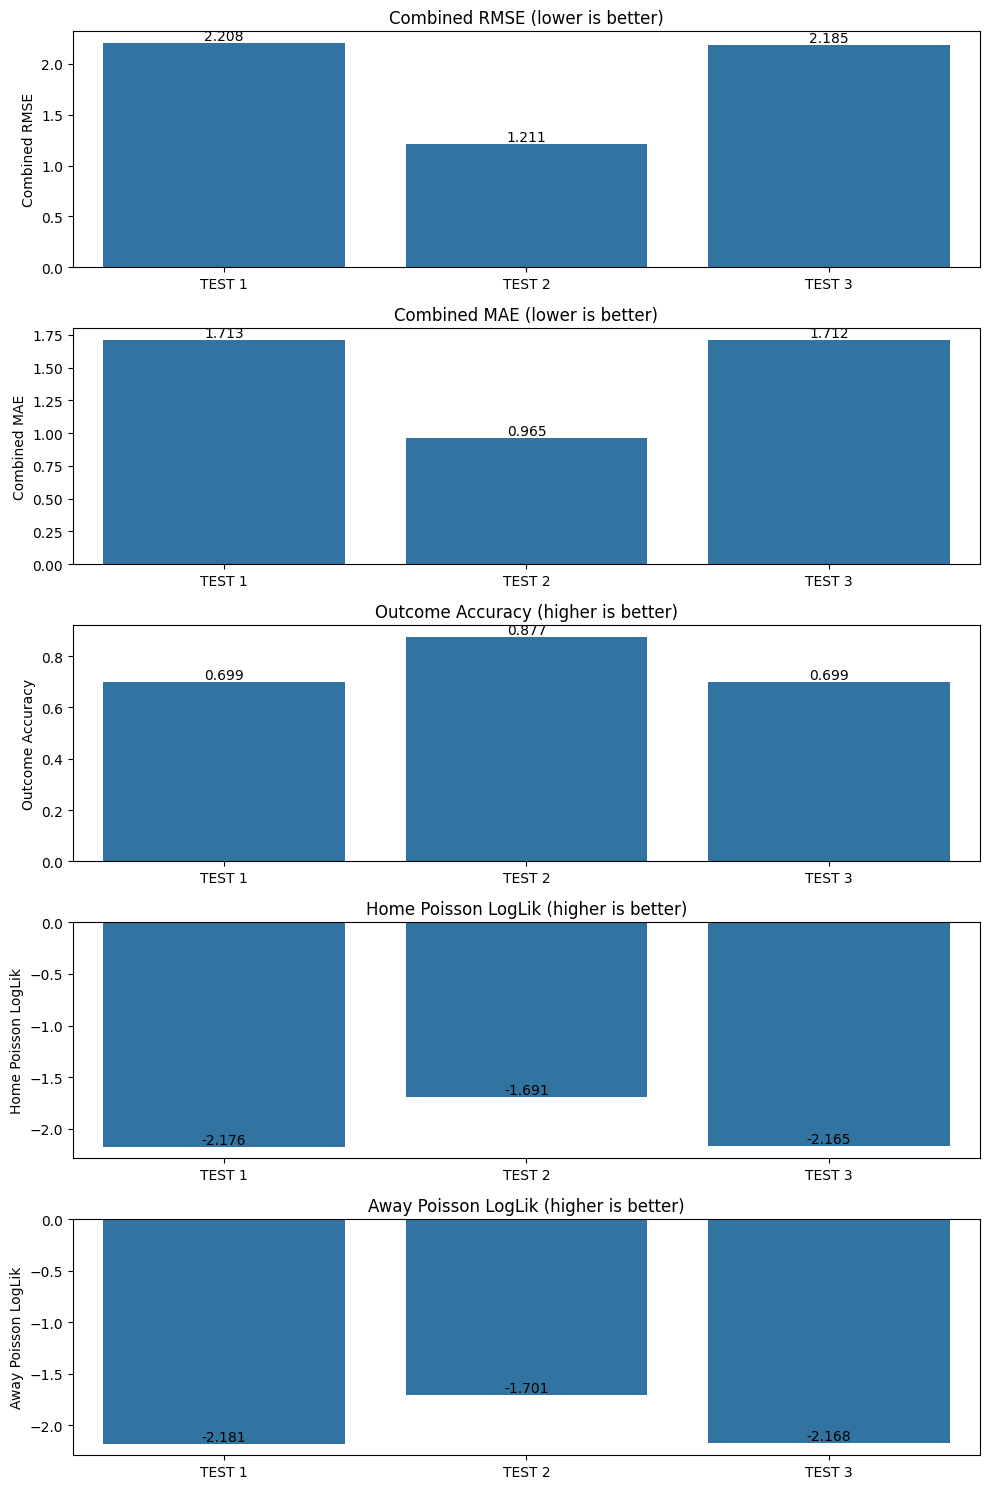

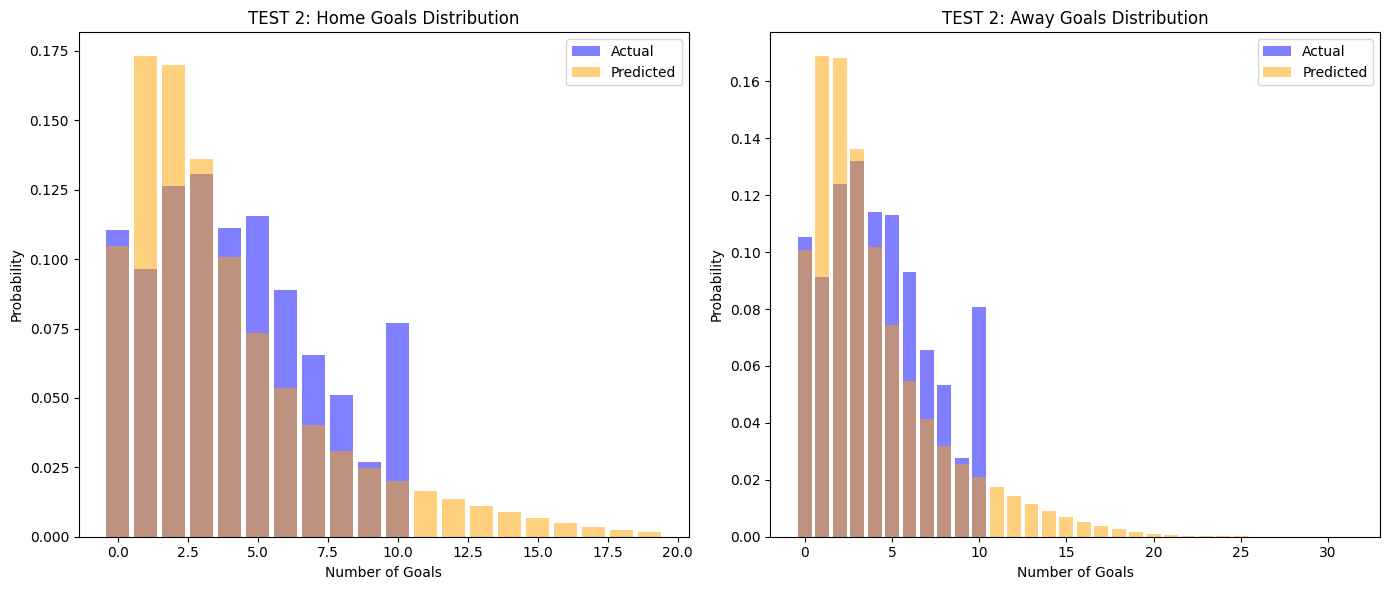

In [34]:
def run_evaluations():
    # Create merged test data with actual goals for evaluation
    test_data = pd.merge(test_home_team_original, test_away_team_original, on='ID', suffixes=('_home', '_away'))

    # Train all models
    model1_home, model1_away = train_test1()
    model2_tuple = train_test2()
    model3_tuple = train_test3()

    # Generate predictions
    test1_home_pred, test1_away_pred = predict_test1(model1_home, model1_away)
    test2_home_pred, test2_away_pred = predict_test2(model2_tuple)
    test3_home_pred, test3_away_pred = predict_test3(model3_tuple)

    # Scale predictions appropriately if needed
    # (TEST 1 and 2 predict avg goals, TEST 3 predicts sum goals)
    # Make sure all predictions are on the same scale!

    # Run evaluation
    results, comparison_fig, calibration_fig = evaluate_test_models(
        test_data,
        test1_home_pred, test1_away_pred,
        test2_home_pred, test2_away_pred,
        test3_home_pred, test3_away_pred
    )

    return results, comparison_fig, calibration_fig

# Run everything
results, comparison_fig, calibration_fig = run_evaluations()

# PREDICT WINNER

In [35]:
def predict_winner(model_tuple, home_team_id, away_team_id):
    # Get the expected goals
    poisson_home, poisson_away, scaler, features = model_tuple

    # Get team data for the specific matchup
    home_team_data = test_home_team_original[test_home_team_original['ID'] == home_team_id]
    away_team_data = test_away_team_original[test_away_team_original['ID'] == away_team_id]

    # Merge the data
    matchup_data = home_team_data.merge(away_team_data, on="ID", suffixes=("_home", "_away"))

    # Drop non-numeric columns
    matchup_data = matchup_data.drop(columns=["NAME_home", "NAME_away", "LEAGUE_home", "LEAGUE_away"], errors="ignore")

    # Select features
    X_matchup = matchup_data[features]
    X_matchup_scaled = scaler.transform(X_matchup)

    # Predict expected goals
    expected_home_goals = poisson_home.predict(X_matchup_scaled)[0]
    expected_away_goals = poisson_away.predict(X_matchup_scaled)[0]

    max_goals = 10
    home_win_prob = 0
    draw_prob = 0
    away_win_prob = 0

    # Calculate outcome probabilities by simulating all possible score combinations
    for home_goals in range(max_goals):
        for away_goals in range(max_goals):
            p = poisson.pmf(home_goals, expected_home_goals) * poisson.pmf(away_goals, expected_away_goals)
            if home_goals > away_goals:
                home_win_prob += p
            elif home_goals == away_goals:
                draw_prob += p
            else:
                away_win_prob += p

    team_names = {
        "home": home_team_data["NAME_home"].values[0] if "NAME_home" in home_team_data.columns else f"Team {home_team_id}",
        "away": away_team_data["NAME_away"].values[0] if "NAME_away" in away_team_data.columns else f"Team {away_team_id}"
    }

    return {
        "expected_goals": {
            "home": round(expected_home_goals, 2),
            "away": round(expected_away_goals, 2)
        },
        "win_probabilities": {
            team_names["home"]: round(home_win_prob * 100, 2),
            "Draw": round(draw_prob * 100, 2),
            team_names["away"]: round(away_win_prob * 100, 2)
        },
        "predicted_result": "Home" if home_win_prob > max(away_win_prob, draw_prob) else
                          "Draw" if draw_prob > away_win_prob else
                          "Away"
    }

In [36]:
def analyze_team_strengths(model_tuple):
    poisson_home, poisson_away, scaler, features = model_tuple

    # Get feature names without suffixes
    base_features = [f.replace('_home', '').replace('_away', '') for f in features
                     if not (f.endswith('_home') and f.replace('_home', '_away') in features)]

    # Extract coefficients
    home_coefs = dict(zip(features, poisson_home.coef_))
    away_coefs = dict(zip(features, poisson_away.coef_))

    # Analyze which factors most influence scoring
    key_factors = {}
    for base in set(base_features):
        home_key = next((f for f in features if base in f and '_home' in f), None)
        away_key = next((f for f in features if base in f and '_away' in f), None)

        if home_key and away_key:
            key_factors[base] = {
                "home_impact": home_coefs.get(home_key, 0),
                "away_impact": away_coefs.get(away_key, 0)
            }

    # Sort by overall importance (sum of absolute values)
    sorted_factors = sorted(key_factors.items(),
                           key=lambda x: abs(x[1]['home_impact']) + abs(x[1]['away_impact']),
                           reverse=True)

    return sorted_factors

In [37]:
# Train the model
model = train_test2()

# Predict a match outcome
match_prediction = predict_winner(model, home_team_id=12303, away_team_id=12303)
print(f"Expected score: {match_prediction['expected_goals']['home']} - {match_prediction['expected_goals']['away']}")
print(f"Win probabilities: {match_prediction['win_probabilities']}")
print(f"Predicted winner: {match_prediction['predicted_result']}")

# Analyze team strengths
team_strengths = analyze_team_strengths(model)
print("Most important factors for team performance:")
for factor, impacts in team_strengths[:5]:
    print(f"{factor}: Home impact={impacts['home_impact']:.4f}, Away impact={impacts['away_impact']:.4f}")

Expected score: 0.93 - 2.68
Win probabilities: {'Team 12303': np.float64(74.52), 'Draw': np.float64(14.95)}
Predicted winner: Away
Most important factors for team performance:
GOALS_sum: Home impact=0.6210, Away impact=0.6281
GAME_LOST_5_last_match_sum: Home impact=0.1014, Away impact=0.2345
GAME_LOST_5_last_match_avg: Home impact=-0.0859, Away impact=-0.2169
GAME_WON_5_last_match_avg: Home impact=-0.0279, Away impact=-0.2597
REDCARDS_5_last_match_sum: Home impact=-0.2351, Away impact=0.0519


# Graphing

In [38]:
# Get predictions from your model
pred_home, pred_away = predict_test2(train_test2())

# Add predictions to the original test dataframes
test_home_team_original['PRED_GOALS'] = pred_home
test_away_team_original['PRED_GOALS'] = pred_away

In [46]:
# dataframe with match results for analysis
match_results = pd.DataFrame({
    'ID': test_home_team_original['ID'],
    'Actual_Home': test_home_team_original['GOALS_avg'],
    'Actual_Away': test_away_team_original['GOALS_avg'],
    'Pred_Home': test_home_team_original['PRED_GOALS'],
    'Pred_Away': test_away_team_original['PRED_GOALS']
})

# Add actual and predicted match outcomes
match_results['Actual_Result'] = np.select(
    [match_results['Actual_Home'] > match_results['Actual_Away'],
     match_results['Actual_Home'] < match_results['Actual_Away'],
     match_results['Actual_Home'] == match_results['Actual_Away']],
    ['Home Win', 'Away Win', 'Draw'],
    default='Draw'
)

match_results['Pred_Result'] = np.select(
    [match_results['Pred_Home'] > match_results['Pred_Away'],
     match_results['Pred_Home'] < match_results['Pred_Away'],
     match_results['Pred_Home'] == match_results['Pred_Away']],
    ['Home Win', 'Away Win', 'Draw'],
    default='Draw'
)

# Actual vs Predicted Goals Distribution

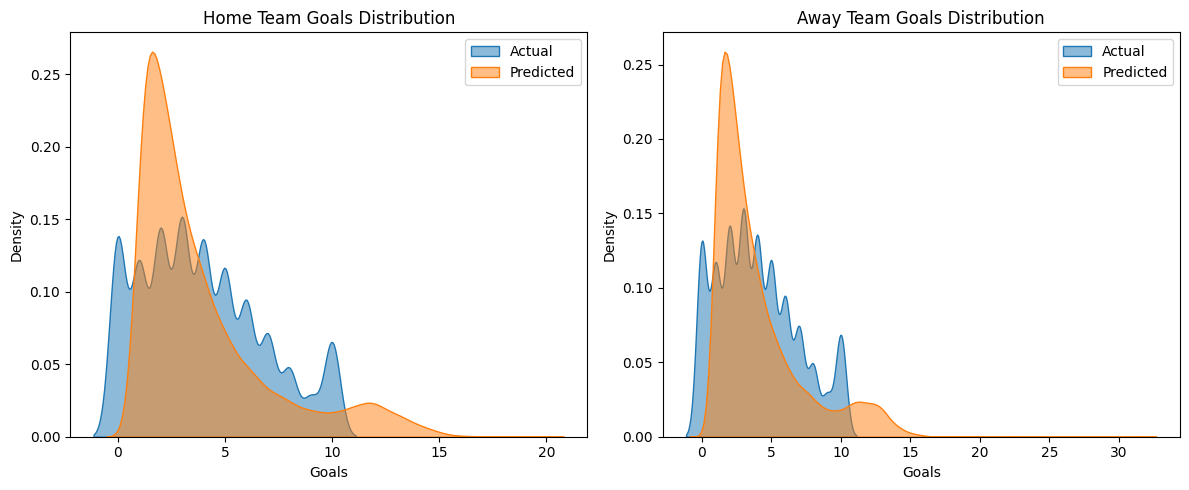

In [47]:
plt.figure(figsize=(12, 5))

# Home Team
plt.subplot(1, 2, 1)
sns.kdeplot(test_home_team_original['GOALS_avg'], label='Actual', fill=True, alpha=0.5)
sns.kdeplot(test_home_team_original['PRED_GOALS'], label='Predicted', fill=True, alpha=0.5)
plt.title('Home Team Goals Distribution')
plt.xlabel('Goals')
plt.ylabel('Density')
plt.legend()

# Away Team
plt.subplot(1, 2, 2)
sns.kdeplot(test_away_team_original['GOALS_avg'], label='Actual', fill=True, alpha=0.5)
sns.kdeplot(test_away_team_original['PRED_GOALS'], label='Predicted', fill=True, alpha=0.5)
plt.title('Away Team Goals Distribution')
plt.xlabel('Goals')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

# Accuracy visualization


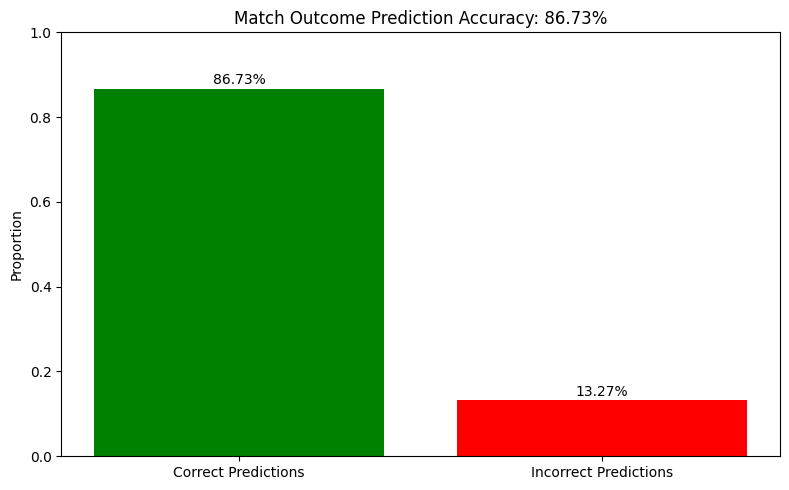

In [48]:
correct_predictions = match_results['Actual_Result'] == match_results['Pred_Result']
accuracy = accuracy_score(match_results['Actual_Result'], match_results['Pred_Result'])

plt.figure(figsize=(8, 5))
plt.bar(['Correct Predictions', 'Incorrect Predictions'],
        [accuracy, 1-accuracy],
        color=['green', 'red'])
plt.title(f'Match Outcome Prediction Accuracy: {accuracy:.2%}')
plt.ylim(0, 1)
plt.ylabel('Proportion')
for i, v in enumerate([accuracy, 1-accuracy]):
    plt.text(i, v + 0.01, f'{v:.2%}', ha='center')
plt.tight_layout()
plt.show()


# Confusion Matrix of Match Outcome Predictions

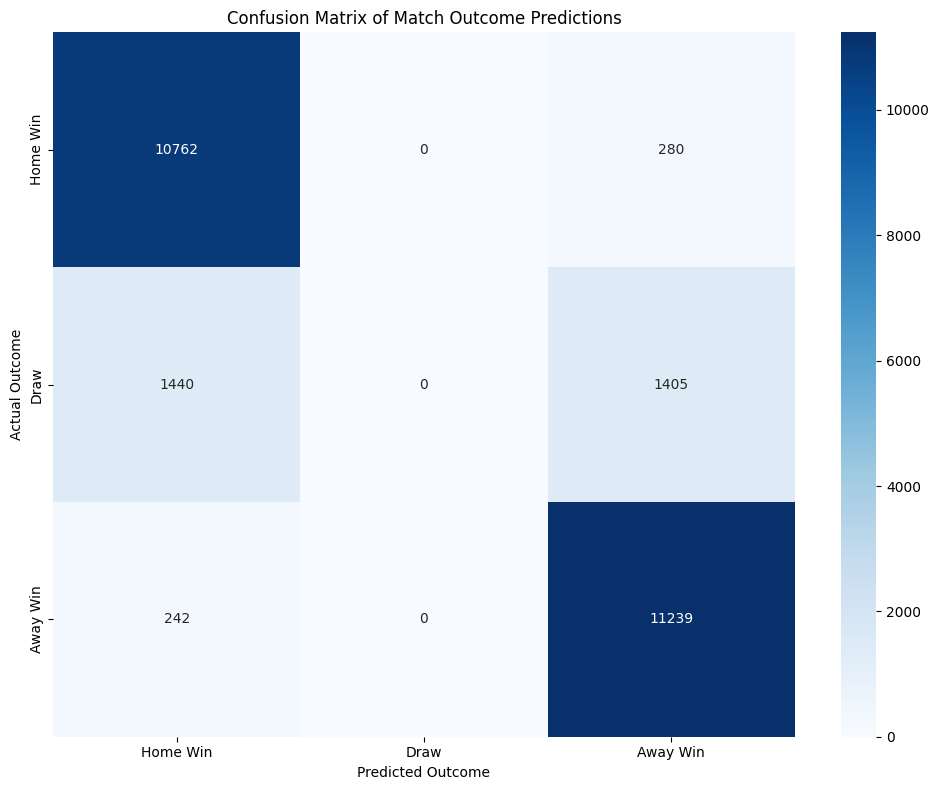

In [49]:
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(match_results['Actual_Result'], match_results['Pred_Result'],
                               labels=['Home Win', 'Draw', 'Away Win'])
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Home Win', 'Draw', 'Away Win'],
            yticklabels=['Home Win', 'Draw', 'Away Win'])
plt.title('Confusion Matrix of Match Outcome Predictions')
plt.xlabel('Predicted Outcome')
plt.ylabel('Actual Outcome')
plt.tight_layout()
plt.show()

# Goal Difference Analysis

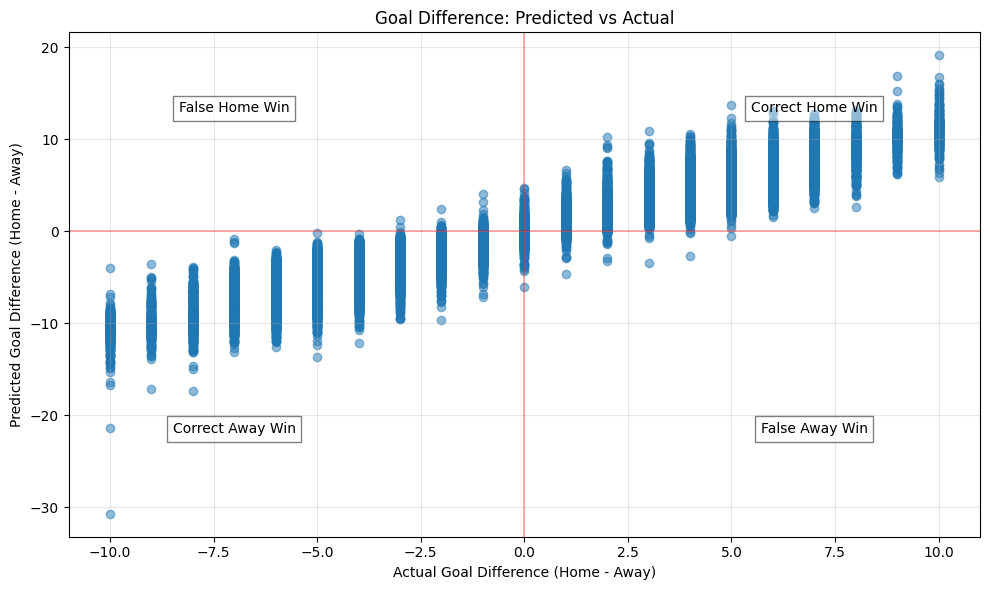

In [50]:
match_results['Actual_Goal_Diff'] = match_results['Actual_Home'] - match_results['Actual_Away']
match_results['Pred_Goal_Diff'] = match_results['Pred_Home'] - match_results['Pred_Away']

plt.figure(figsize=(10, 6))
plt.scatter(match_results['Actual_Goal_Diff'], match_results['Pred_Goal_Diff'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='r', linestyle='-', alpha=0.3)
plt.xlabel('Actual Goal Difference (Home - Away)')
plt.ylabel('Predicted Goal Difference (Home - Away)')
plt.title('Goal Difference: Predicted vs Actual')

# Add quadrant labels
plt.text(max(match_results['Actual_Goal_Diff'])*0.7, max(match_results['Pred_Goal_Diff'])*0.7,
         'Correct Home Win', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
plt.text(min(match_results['Actual_Goal_Diff'])*0.7, min(match_results['Pred_Goal_Diff'])*0.7,
         'Correct Away Win', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
plt.text(min(match_results['Actual_Goal_Diff'])*0.7, max(match_results['Pred_Goal_Diff'])*0.7,
         'False Home Win', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
plt.text(max(match_results['Actual_Goal_Diff'])*0.7, min(match_results['Pred_Goal_Diff'])*0.7,
         'False Away Win', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Match Outcome Probability Matrix

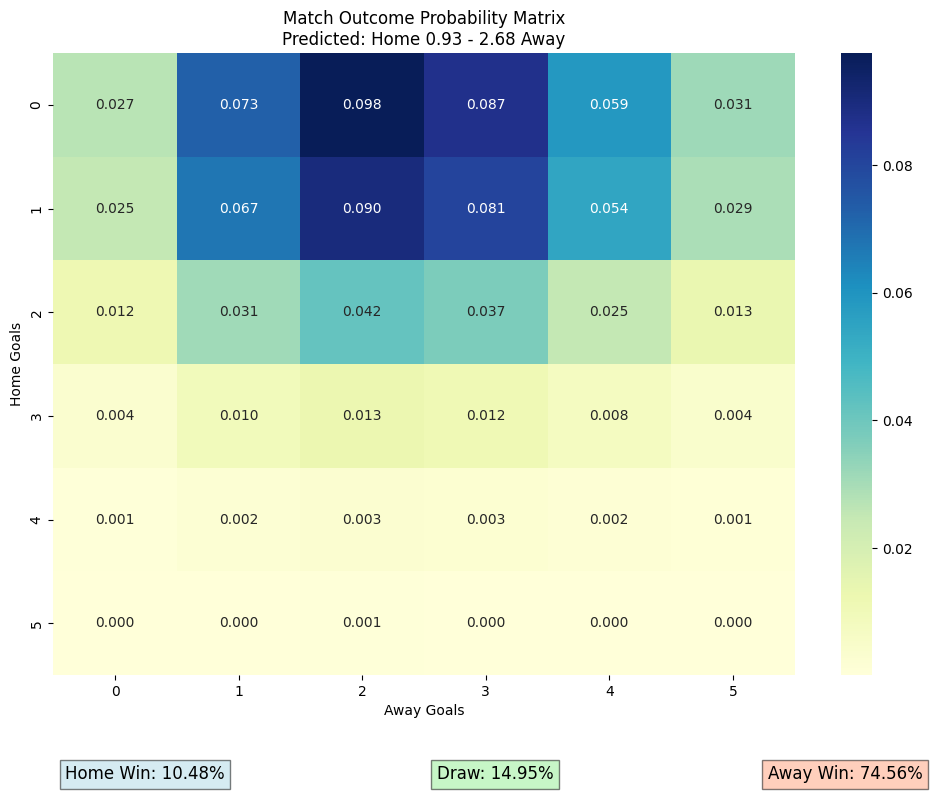

In [51]:
def calculate_match_probabilities(home_goals, away_goals, max_goals=10):
    """Calculate probability matrix for match outcomes based on Poisson distribution"""
    home_probs = [poisson.pmf(i, home_goals) for i in range(max_goals+1)]
    away_probs = [poisson.pmf(i, away_goals) for i in range(max_goals+1)]

    matrix = np.outer(home_probs, away_probs)

    # Calculate outcome probabilities
    home_win_prob = np.sum(np.tril(matrix, -1))
    draw_prob = np.sum(np.diag(matrix))
    away_win_prob = np.sum(np.triu(matrix, 1))

    return home_win_prob, draw_prob, away_win_prob, matrix

# Get an example match to visualize
example_index = 0  # Can be changed to any match index
example_home_goals = match_results['Pred_Home'].iloc[example_index]
example_away_goals = match_results['Pred_Away'].iloc[example_index]

home_win_prob, draw_prob, away_win_prob, probability_matrix = calculate_match_probabilities(
    example_home_goals, example_away_goals)

# Visualize probability matrix for the example match
plt.figure(figsize=(10, 8))
max_goals = 5  # Limit for better visualization
sns.heatmap(probability_matrix[:max_goals+1, :max_goals+1], annot=True, cmap="YlGnBu", fmt='.3f')
plt.title(f'Match Outcome Probability Matrix\nPredicted: Home {example_home_goals:.2f} - {example_away_goals:.2f} Away')
plt.xlabel('Away Goals')
plt.ylabel('Home Goals')

# Add outcome probabilities
plt.figtext(0.15, 0.02, f'Home Win: {home_win_prob:.2%}', ha='center', fontsize=12,
            bbox=dict(facecolor='lightblue', alpha=0.5))
plt.figtext(0.5, 0.02, f'Draw: {draw_prob:.2%}', ha='center', fontsize=12,
            bbox=dict(facecolor='lightgreen', alpha=0.5))
plt.figtext(0.85, 0.02, f'Away Win: {away_win_prob:.2%}', ha='center', fontsize=12,
            bbox=dict(facecolor='lightsalmon', alpha=0.5))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()